# Predicting Horse Race Outcomes : using Random Forest Regressor model #

The aim was to make the model generalized to any country or race, by the feature engineering. This model takes any combination or number of horses that are going to be in a race, and predicts their finishing position based on horse and jockey attributes. This model could have done with much more fine tuning of features and hyperparamters, time was a constraint, but it tends to be generally giving more correct predictions more than incorrect predictions. 


In [ ]:
!pip install missingno
#https://github.com/ResidentMario/missingno

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#definitions
def normalize(df, column_name):
    df_norm=(df[column_name]-df[column_name].min()) / (df[column_name].max() - df[column_name].min())   
    return df_norm
def convert_to_seconds(time_str):
    mins, sec, millisec= time_str.split('.')
    total_milliseconds= (int(mins)*60*1000)+(int(sec)*1000)+int(millisec)
    seconds= total_milliseconds/1000
    return seconds

In [3]:
#initializing raw data
details_rawdata = pd.read_csv(r'race_details_20240101_20240131.csv', encoding='utf-8' )
results_rawdata = pd.read_csv(r'race_results_20240101_20240131.csv', encoding='utf-8') #to display Turkish characters correctly

In [4]:
print('Example: race 1...')
results_rawdata[['race_date','race_city','race_no', 'result']].head(6)

Example: race 1...


,race_date,race_city,race_no,result
0,2024-01-01,Bursa,1,1
1,2024-01-01,Bursa,1,2
2,2024-01-01,Bursa,1,3
3,2024-01-01,Bursa,1,4
4,2024-01-01,Bursa,1,5
5,2024-01-01,Bursa,1,6


In [5]:
print('...race 2')
results_rawdata[['race_date', 'race_city', 'race_no', 'result']].iloc[6:16]

...race 2


,race_date,race_city,race_no,result
6,2024-01-01,Bursa,2,1
7,2024-01-01,Bursa,2,2
8,2024-01-01,Bursa,2,3
9,2024-01-01,Bursa,2,4
10,2024-01-01,Bursa,2,5
11,2024-01-01,Bursa,2,6
12,2024-01-01,Bursa,2,7
13,2024-01-01,Bursa,2,8
14,2024-01-01,Bursa,2,9
15,2024-01-01,Bursa,3,1


**Why I chose to do a Random Forest regression?**

The process to ending up on this model was a series of trial and error. Given that the race has discrete outcomes/positions (race_no) I first tried classification with XGBoost.

Naturally, I set the 'results' column to the targets (outputs) - these are direct identifiers of race outcomes.
I saw that each race could have any amount of horses between 2 to 18. Initially I had tried an XGBoost classification on data where I dropped race events with more than 6 horses (or some number that kept a good amount of data like the histogram below). 
This was to keep input-output sizes fixed. And even before that I had tried using all the datapoints straight (no grouping of them by race) and I tried predicting a single horses position, the accuracies of both methods were very random (though my preprocessing at that time was not as good as this current version).

However I felt that still was not enough and needed more datapoints since 4300 is typically a low amount of data to begin with. So I normalized the 'results' column so that the different number of horses per race would not affect the output-input sizes and tried this Random Forest Regression. 

However I also researched about horse racing online, checked many websites for information, and I found that often horse races (for Handicap conditions) are assigned a handicap score so that all participants (horse and jockey) in a single race should theoretically be at the finish line at the same time. Factors like this for bookmaking ensures more controlled odds, so that all the horses have a very even chance and that it's very unlikely to predict outcomes when betting.

By normalizing the result column I also created a linear mapping for a regression.

To also grasp an idea of what the data meant I looked at various websites and searchs:
https://www.racingandsports.com.au/thoroughbred/jockey/s-hlengwa/74789
https://m.hollywoodbets.net/betting/8/horse-racing/country/2/south-africa/tournament/3609334/hollywoodbets-greyville-poly/event/6622789/1
https://pedigree-dynamics.com.au/glossary-of-breeding-terminology/
https://www.tjk.org/en/YarisSever/YarisSever/Index

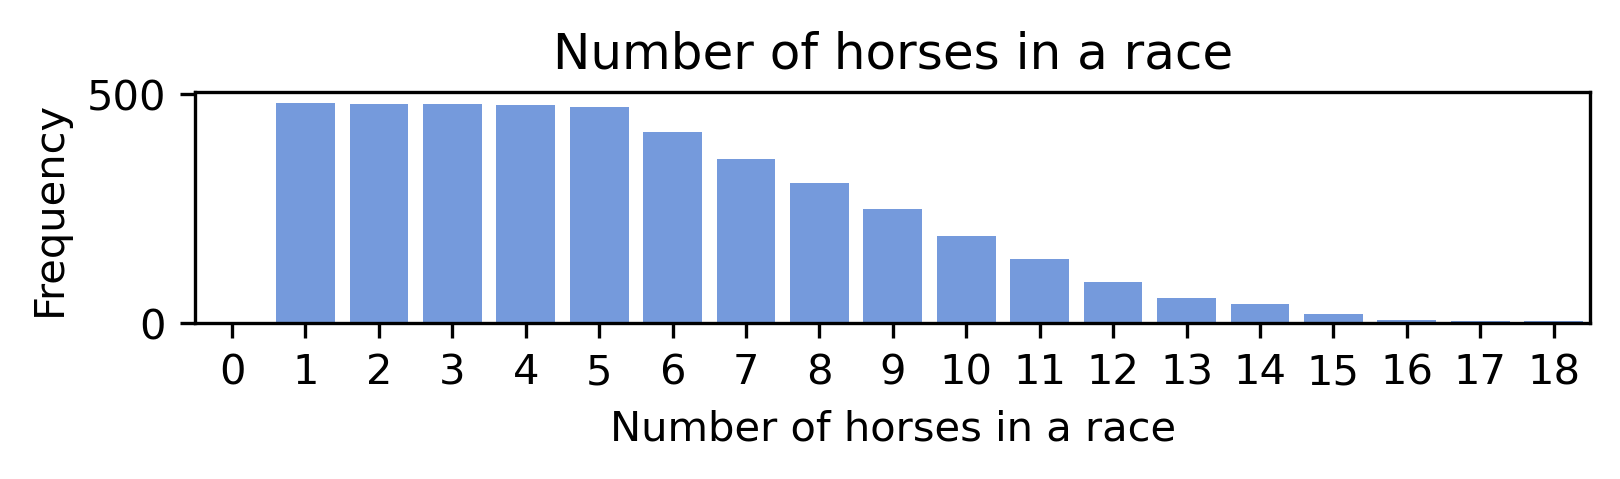

In [6]:
# determining features and target
bin_counts = results_rawdata['result'].value_counts().sort_index()
plt.figure(figsize=(6, 1), dpi=300)
sns.barplot(x=bin_counts.index, y=bin_counts.values, color='cornflowerblue')
plt.xlabel('Number of horses in a race')
plt.ylabel('Frequency')
plt.title('Number of horses in a race')
plt.show()


**Data cleaning, pre-processing and feature engineering**:
<br>
**1. Datapoints I chose to drop and why:**<br>
'finish_time','race_length', : changed to speed<br>
'race_race_group':races will happen within a single race group anyway<br>
"horse_rate": not sure what this is, but with more time would have iterated more features and tried this<br>
"horse_psf_rank": observed redundancy with psf_rate<br>
"best_rating": visibly not much correlation to the results, could have used it to calculate a sport "form" type metric in another life<br>
"Horse_starting_box_no":most starting boxes are said to be made so horses come out identical<br>
"jockey_name",'horse_trainer', 'horse_owner', horse_name',': takes away from a generalized model that can focus prediction for any input horses attributes.<br>
"race_no","race_date",'race_city': merged into race_info and became a unique identifier for all the races.<br>
horse_origin': could play a role...<br>
'horse_sire','horse_dam', 'hors_broodmare_sire': could also play a role in this datapool accuracy, but less so for a general pool<br>
'horse_margin': way too much missing information<br>
'horse_late_start': too much missing info<br>
'horse_accessories': ran out of time but i did encode it in previous attempts<br>



**2. Features added:**<br>

**race_info**<br>
combination of race_date, race_no and race_city

**speed** <br>
---> combining the 2 raw datasets<br>
track_length/horse_race_degree = distance(m)/time(s) = speed


<Figure size 200x100 with 0 Axes>

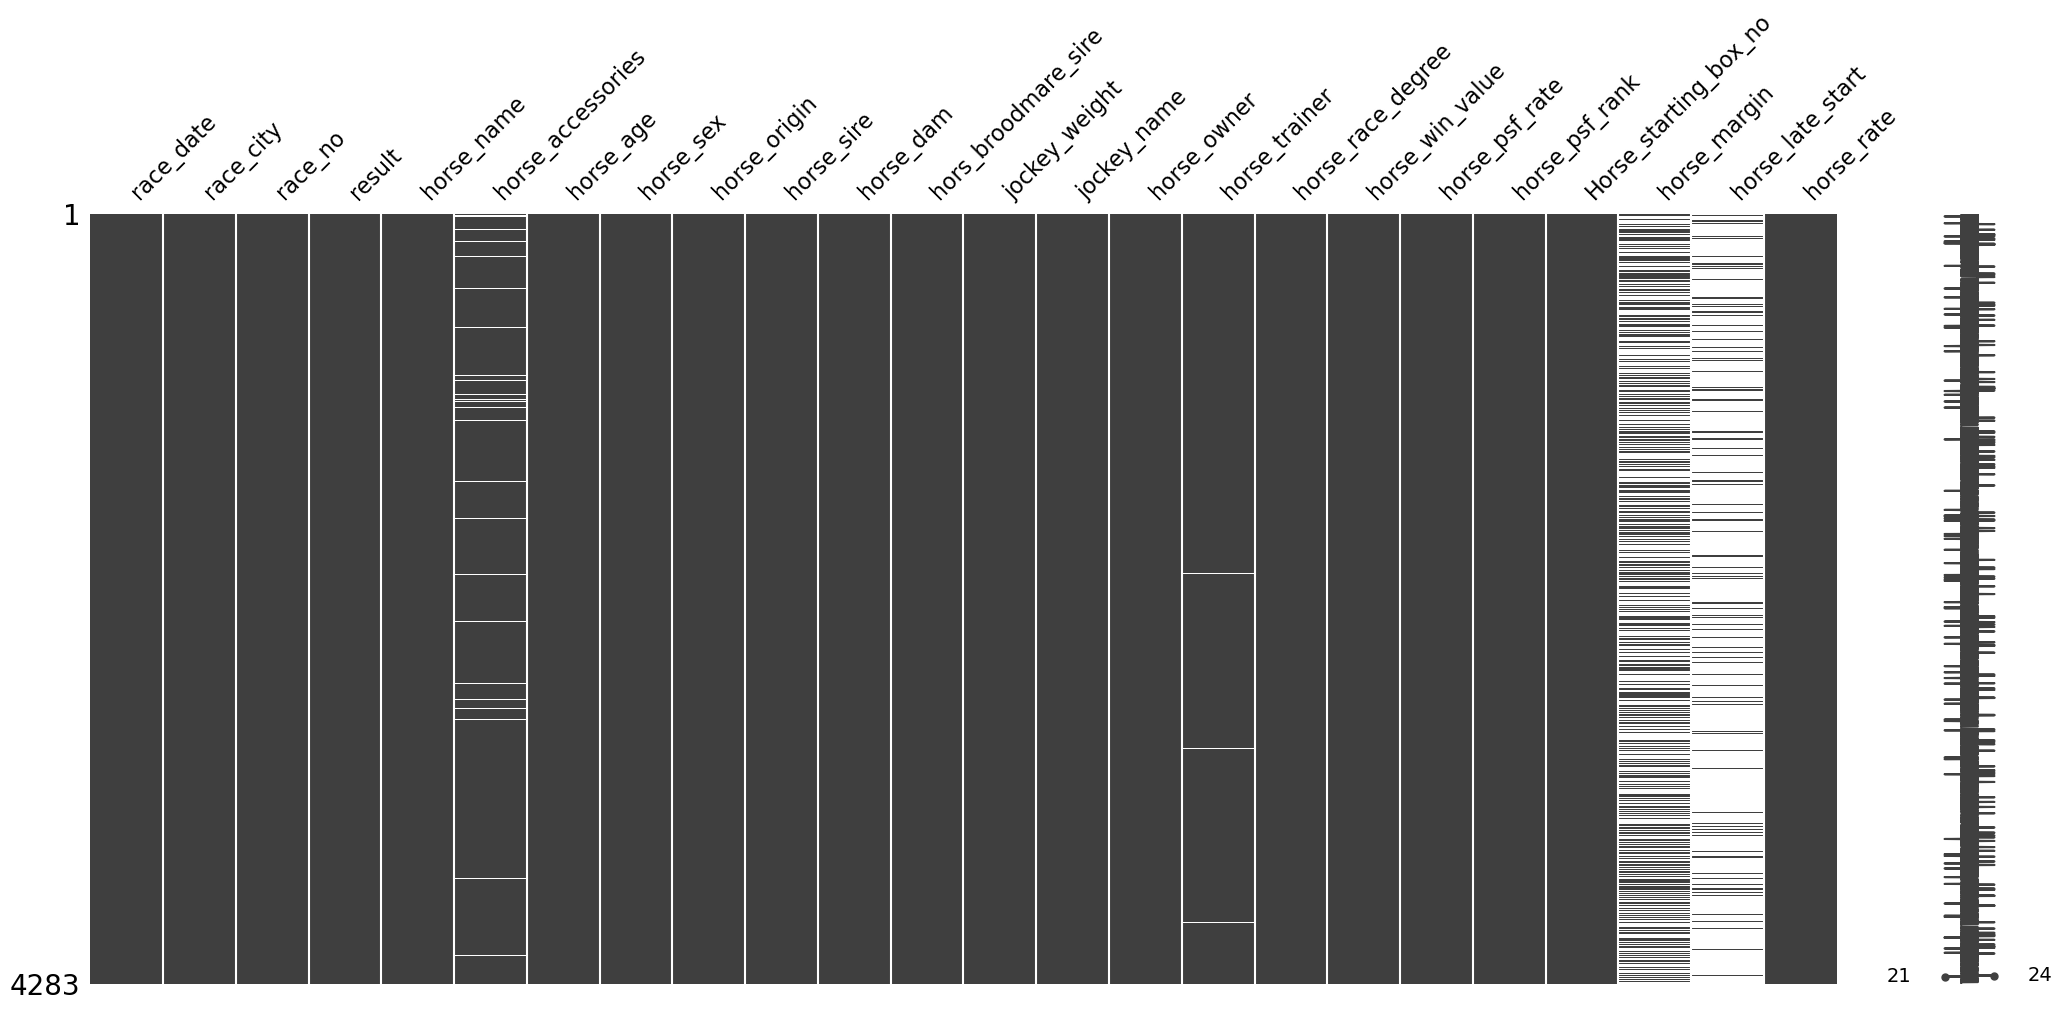

In [7]:
#check for missing data
import missingno as msno
plt.figure(figsize=(2, 1)) 
msno.matrix(results_rawdata)
plt.show()

In [8]:
#merge race details into race results
race_combo = pd.merge(results_rawdata, details_rawdata, on=['race_date', 'race_city', 'race_no'], how='left')
race_combo['race_info'] = race_combo['race_date'] + '_' + race_combo['race_city'] + '_' + race_combo['race_no'].astype(str)

#group by race_info and rescale result groups between 0 and 1
race_combo_grouped = race_combo.groupby('race_info')

for name, group in race_combo_grouped:
    group['result']=normalize(group, 'result')
    race_combo.loc[race_combo['race_info'] == name,'result'] = group['result']
    
#strip text and convert to numerical data 
race_combo['horse_age'] = race_combo['horse_age'].str.replace('y', '').astype(int)
race_combo['race_age_group'] = race_combo['race_age_group'].apply(lambda x: (''.join(c for c in x if (c.isdigit() or c =='.'))))

race_combo = race_combo.rename(columns={'horse_race_degree': 'finish_time'})
race_combo['finish_time'] = race_combo['finish_time'].replace('Derecesiz', np.nan)# fill undetermined time 
race_combo['finish_time'] = race_combo['finish_time'].apply(lambda x: convert_to_seconds(x) if pd.notnull(x) else np.nan)

#new combination feature
race_combo['speed'] = race_combo.apply(lambda row: row['race_length'] / row['finish_time'], axis=1)
race_combo['speed'] = normalize(race_combo, 'speed')

#dropped
race_combo = race_combo.drop(['finish_time','race_length', 'race_race_group',"horse_rate","horse_psf_rank","best_rating","race_sex_group","Horse_starting_box_no","jockey_name","race_no","race_date",'horse_trainer', 'horse_owner', 'race_city','horse_name','horse_origin', 'horse_sire','horse_dam', 'hors_broodmare_sire','horse_margin', 'horse_late_start', 'horse_accessories', 'Horse_starting_box_no' ] , axis=1)

#converting text to num
race_combo['horse_sex'] = race_combo['horse_sex'].replace({'m': 0, 'f': 1})
race_combo['race_age_group'] = race_combo['race_age_group'].replace({3: 0, 4: 1})
race_combo['race_track_type'] = race_combo['race_track_type'].replace({"Dirt": 0, "Dirt (Polytrack)": 1})
race_combo['horse_win_value'] = race_combo['horse_win_value'].astype(float)

#one-hot encode categorical columns
columns_to_encode = ['horse_age', 'race_type', 'race_age_group', 'race_track_type', 'race_track_condition']
#rescale columns between 0 and 1
columns_to_rescale = ['result', 'jockey_weight', 'horse_win_value', 'horse_psf_rate']
for column in columns_to_rescale:
    race_combo[column] = normalize(race_combo, column)
for column in race_combo.columns:
    unique_values = race_combo[column].nunique()
    print(column, ': ', unique_values) #check number of unqiue values

race_combo_encoded = pd.get_dummies(race_combo, columns=columns_to_encode, drop_first=True)
race_combo_encoded = race_combo_encoded.dropna()

#check if a column is bool and convert true to 1 and false to 0
for column in race_combo_encoded.columns:
    if race_combo_encoded[column].dtype == bool:
        race_combo_encoded[column] = race_combo_encoded[column].astype(int)
        
race_combo_encodedRF = race_combo_encoded

#https://stackoverflow.com/questions/74793282/removing-all-text-from-a-column
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
#https://www.kdnuggets.com/2023/07/pandas-onehot-encode-data.html

result :  97
horse_age :  9
horse_sex :  2
jockey_weight :  15
horse_win_value :  1093
horse_psf_rate :  76
race_type :  20
race_age_group :  2
race_track_type :  2
race_track_condition :  4
race_info :  480
speed :  3692


row numbers with nan values: []


<Figure size 200x100 with 0 Axes>

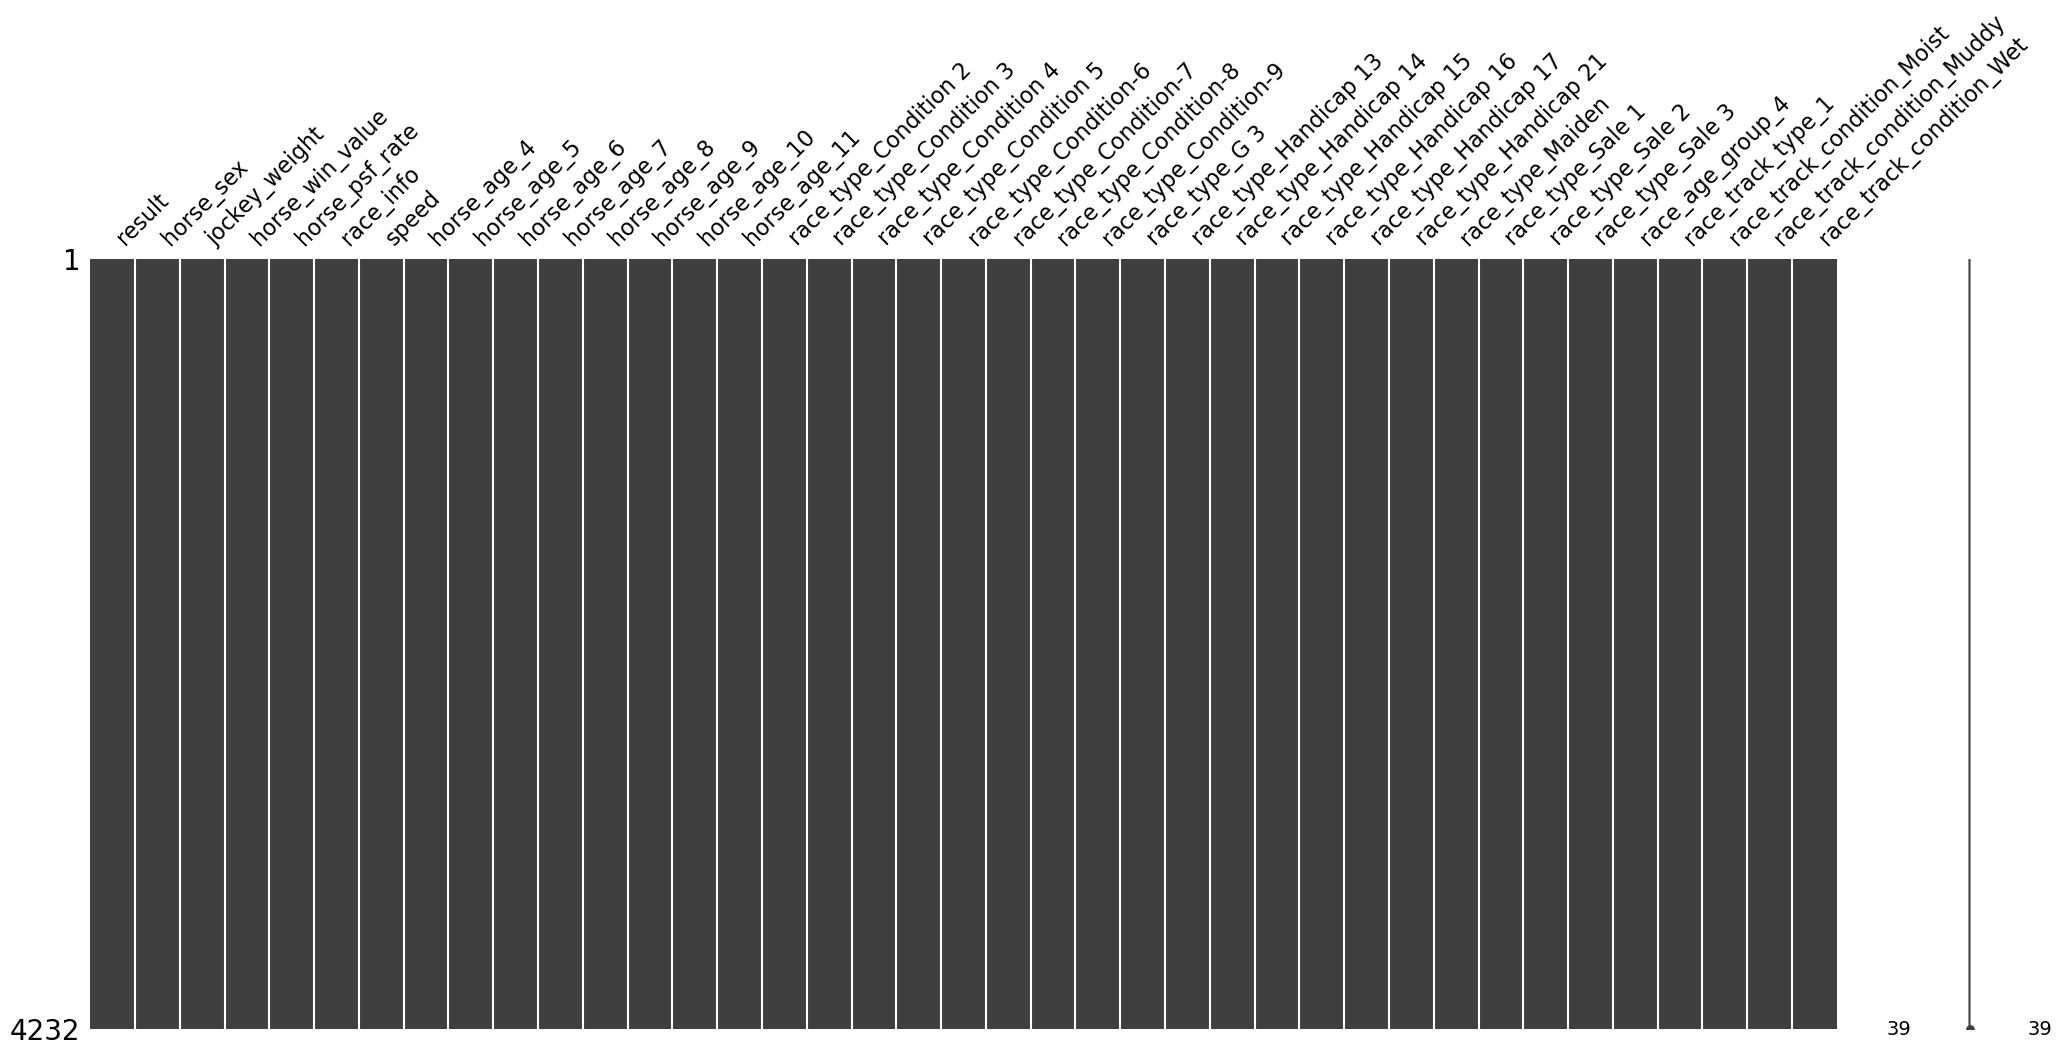

In [9]:
#checking for missing/nan cells
nan_rows = race_combo_encodedRF[race_combo_encoded.isnull().any(axis=1)]
nan_row_numbers = nan_rows.index.tolist()
print(f"row numbers with nan values: {nan_row_numbers}")

#plot for missing data
import missingno as msno
plt.figure(figsize=(2, 1)) 
msno.matrix(race_combo_encodedRF)
plt.show()

In [10]:
#exporting clean data
#race_combo_encodedRF.to_csv(r'race_combo_encodedRF.csv', index=False)

In [11]:
#importing cleaned data 
#race_combo_encodedRF = pd.read_csv(r'race_combo_encodedRF.csv', encoding='utf-8' )

In [12]:
# Extract testing dataset
unique_races = race_combo_encodedRF['race_info'].unique()[:20]

testing_dataset = race_combo_encodedRF[race_combo_encodedRF['race_info'].isin(unique_races)].copy()
training_dataset = race_combo_encodedRF[~race_combo_encodedRF['race_info'].isin(unique_races)].copy()

#only for eval below:
# for testing on a race by race basis just like a bookie or better would do
testing_groups = testing_dataset.groupby('race_info')

X_train = training_dataset.drop(columns=['result', 'race_info'])
y_train = training_dataset['result']
X_test = testing_dataset.drop(columns   =['result', 'race_info'])    
y_test = testing_dataset['result']

#https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.__iter__.html#pandas.core.groupby.DataFrameGroupBy.__iter__

**Random Forest Regressor**<br>
Each decision tree in the forest makes its own prediction (its "best guess") about the target value. Then, the random forest takes an average of all these predictions from each tree to give a final, single prediction. This averaging process is what makes it a regression model as it results in a continuous value rather than a category, which would be classification. So the final prediction in random forest regression is essentially the average of all the trees "best guesses."

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

#GRID SEARCH
#takes so long to run 
#randomforest_params = {"n_estimators": [50,100,500],
#                       'criterion': ['squared_error'],
#                       "max_features": ["sqrt", "auto"],
#                       "min_samples_split":np.arange(1,5,1)}

#tuning hyperparams by grid search:
#from sklearn.model_selection import GridSearchCV

#randomforest_regressor = RandomForestRegressor(random_state=36)
#RFR_model= GridSearchCV(estimator=randomforest_regressor, param_grid=randomforest_params, cv=5)
#RFR_model.fit(X_train, y_train)
#print("best params: ", randomforest_model.best_params_)

#https://github.com/icanerdogan/Machine-Learning-Tutorial/blob/master/Regresyon/RandomForestRegressor.ipynb
#https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

In [14]:
#model
RFR_model = RandomForestRegressor(oob_score=True, n_estimators=1000, max_depth=20, random_state=32)
RFR_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=1000, oob_score=True,
                      random_state=32)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RFR_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Average CV Score:", scores.mean())

In [15]:
#EVAL
#y_pred = ml_model.predict(X_test)
total_match = 0
total_close = 0
total_incorrect = 0
total_rows = 0

tot_y_test=[]
tot_y_pred=[]
for race_id, group in testing_groups: 
    X_test = group.drop(columns=['result', 'race_info'])
    y_test = group['result']
    
    #perform prediction for the current group
    y_pred = RFR_model.predict(X_test)
    ranked_pred = pd.Series(y_pred).rank(ascending=False).tolist()#after using rank it assigns numbers 1, 2, 3....etc
    ranked_act = pd.Series(y_test).rank(ascending=False).tolist()


    comparison_df = pd.DataFrame({
        'Actual': ranked_act,
        'Predicted': ranked_pred
    })
    #new 'custom_metric'  column 
    comparison_df['Comparison'] = 'INCORRECT'#initializes all horse pred as incorrect
    
    #count frequency of correct pred
    comparison_df.loc[comparison_df['Predicted'] == comparison_df['Actual'], 'Comparison'] = 'CORRECT'
    comparison_df.loc[(abs(comparison_df['Predicted'] - comparison_df['Actual']) <= 1) & (comparison_df['Predicted'] != comparison_df['Actual']), 'Comparison'] = 'CLOSE'
    #print(comparison_df)
    tot_y_test.append(ranked_pred)
    tot_y_pred.append(ranked_act)

    match_count = comparison_df[comparison_df['Comparison'] == 'CORRECT'].shape[0]
    close_count = comparison_df[comparison_df['Comparison'] == 'CLOSE'].shape[0]
    incorrect_count = comparison_df[comparison_df['Comparison'] == 'INCORRECT'].shape[0]
    
    total_match += match_count
    total_close += close_count
    total_incorrect += incorrect_count
    total_rows += comparison_df.shape[0]
    

#% accuracy
match_percentage = (total_match/total_rows)*100
close_percentage = (total_close/total_rows)*100
incorrect_percentage =(total_incorrect/total_rows)*100
print(f"Total Match: {total_match} ({match_percentage:.2f}%)")
print(f"Total Close: {total_close} ({close_percentage:.2f}%)")
print(f"Total Incorrect: {total_incorrect} ({incorrect_percentage:.2f}%)")
print('example:')
print('These are race finishing positions of horses.')
comparison_df
#https://www.youtube.com/watch?v=YUsx5ZNlYWc
#https://www.geeksforgeeks.org/random-forest-regression-in-python/

Total Match: 57 (40.71%)
Total Close: 41 (29.29%)
Total Incorrect: 42 (30.00%)
example:
These are race finishing positions of horses.


,Actual,Predicted,Comparison
0,6.0,6.0,CORRECT
1,5.0,5.0,CORRECT
2,4.0,4.0,CORRECT
3,3.0,2.0,CLOSE
4,2.0,3.0,CLOSE
5,1.0,1.0,CORRECT


**Evaluation and Visualization**<br>

The matches above are referring to whether a single horse prediction was correctly predicted- a match, or if it was closely predicted (to the error of +-position) or incorrectly predicted.

In [16]:
# unseen data / validation type score:
oob_score = RFR_model.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

Out-of-Bag Score: 0.3617393193733436


In [17]:
def mae(tot_y_test, tot_y_pred):
    m=[]
    for i,j in zip(tot_y_test, tot_y_pred):
        i=np.array(i)
        j=np.array(j)
        Diff = i-j
        MAE = (np.sum(np.abs((Diff))))/len(tot_y_test)
        m.append(MAE)
    return m
mae= mae(tot_y_test, tot_y_pred)

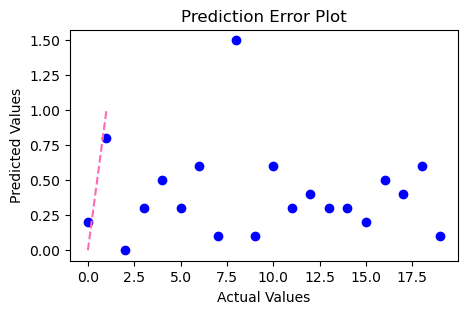

In [19]:
#1. Prediction error plot
plt.figure(figsize=(5, 3))
plt.scatter(range(len(tot_y_test)), mae, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="hotpink", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Error Plot")
plt.show()

**Conclusion and Analysis:**<br>
Feature engineering the average speed of the horse made a huge difference to the information gained as in the Feature importance plot below. With more of that as well as fine-tuning, ML models are extremely good at finding (even small) patterns in highly random games. In particular this method was able to train on individual horse inputs but decide positions for multi-horse races. Its nice system but the results do look very random and don't have high accuracy. Which is also expected for betting game thats inherently built to be more on the random side.

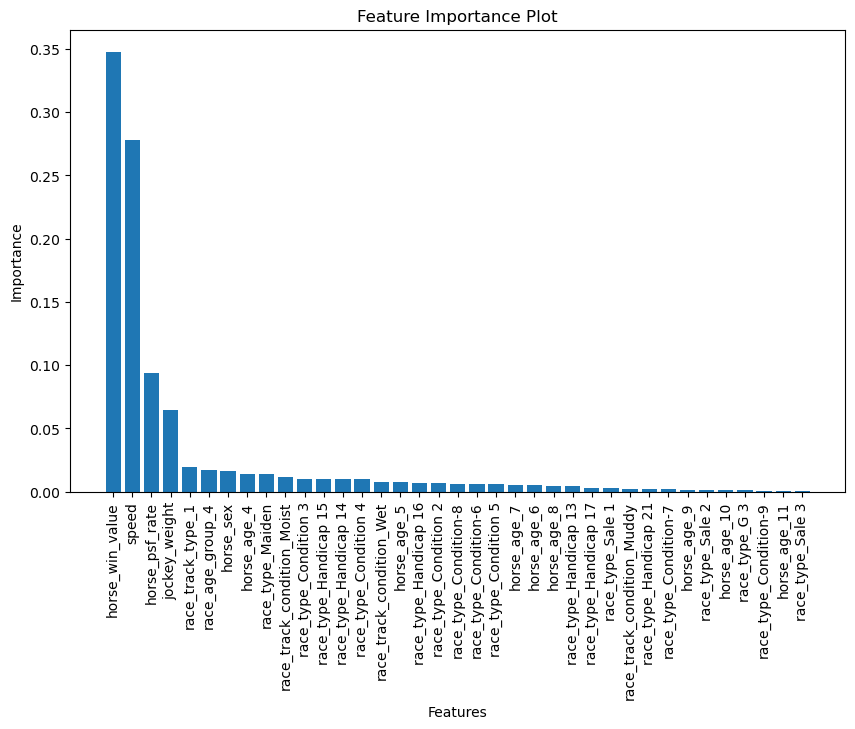

In [21]:
#3. Feature importance plot
importances = RFR_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.title("Feature Importance Plot")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()
